<div style="text-align: center;">
    <span style="font-size:50px;"><b>Speech to Text</b></span>
</div>


# **Load Dependencies**

In [1]:
import os
import pandas as pd
import librosa
import numpy as np
import IPython.display as ipd
import torchaudio
import librosa.display
import matplotlib.pyplot as plt
import random
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim import models

# **Load Data**

In [2]:
# Define the paths to the data directories
BASE_DIR = 'E:\Studies\\11th Semester\\425\\Project\\Dataset\\bengaliai-speech'
train_data_dir = f"{BASE_DIR}/train_mp3s/"  
test_data_dir = f"{BASE_DIR}/test_mp3s/" 
train_csv_path = f"{BASE_DIR}/train.csv" 
domains = f"{BASE_DIR}/examples/" 

path_template = "E:\Studies\\11th Semester\\425\\Project\\Dataset\\bengaliai-speech\\train_mp3s\\{}.mp3"

# Load the train.csv file using pandas
train_df = pd.read_csv(train_csv_path)

# Preview the first few rows of the DataFrame
display(train_df.head())

DOMAINS = os.listdir(f'{BASE_DIR}/examples')

,id,sentence,split
0,000005f3362c,ও বলেছে আপনার ঠিকানা!,train
1,00001dddd002,কোন মহান রাষ্ট্রের নাগরিক হতে চাও?,train
2,00001e0bc131,"আমি তোমার কষ্টটা বুঝছি, কিন্তু এটা সঠিক পথ না।",train
3,000024b3d810,নাচ শেষ হওয়ার পর সকলে শরীর ধুয়ে একসঙ্গে ভোজন...,train
4,000028220ab3,"হুমম, ওহ হেই, দেখো।",train


# **Summary**

In [3]:
# Load audio files and corresponding transcriptions
audio_data = []  # List to store audio data
transcriptions = []  # List to store corresponding transcriptions

for idx, row in train_df.head(5).iterrows():
    audio_file_path = path_template.format(row['id'])

    # Load the audio file using librosa
    audio, sr = librosa.load(audio_file_path, sr=None)

    # Append audio data and transcription to lists
    audio_data.append(audio)
    transcriptions.append(row['sentence'])
    
audio_data = np.array(audio_data,dtype = 'object')
transcriptions = np.array(transcriptions,dtype = 'object')

# Check the shapes of the loaded data
print("Audio data shape:", audio_data.shape)
print("Transcriptions shape:", transcriptions.shape)


Audio data shape: (5,)
Transcriptions shape: (5,)


In [4]:
# Get the total number of audio files in the training and test directories
train_audio_files = os.listdir(train_data_dir)
test_audio_files = os.listdir(test_data_dir)

# Get the total duration of audio data in the training set (in seconds)
train_total_duration = 0
SAMPLES_TAKEN = 10000
for idx, row in train_df.head(SAMPLES_TAKEN).iterrows():
    audio_file_path = path_template.format(row['id'])

test_duration = 0
for test_file in test_audio_files:
    audio_file_path = os.path.join(test_data_dir, str(test_file))
    
# Get the total number of samples in the training data
total_samples = train_df.shape[0]

# Print the data summary
print("Data Summary:")
print(f"Total number of audio files in the training directory: {len(train_audio_files)}")
print(f"Total number of audio files in the test directory: {len(test_audio_files)}")
print(f"Total number of samples in the training data: {total_samples}")

Data Summary:
Total number of audio files in the training directory: 963636
Total number of audio files in the test directory: 3
Total number of samples in the training data: 963636


# **Listen**

In [ ]:
random_indices = [0, 10, 20, 30, 40]

for idx in random_indices:
    row = train_df.iloc[idx]
    audio_file_path = path_template.format(row['id'])

    # Load the audio file using librosa
    audio, sr = librosa.load(audio_file_path, sr=None)

    # Print the transcription and play the audio
    print("Transcription:", row['sentence'])
    ipd.display(ipd.Audio(audio, rate=sr))

In [ ]:
for test_file in test_audio_files:
    audio_file_path = os.path.join(test_data_dir, str(test_file))
    
    # Load the audio file using librosa
    audio, sr = librosa.load(audio_file_path, sr=None)
    ipd.display(ipd.Audio(audio, rate=sr))

# **Visualization**

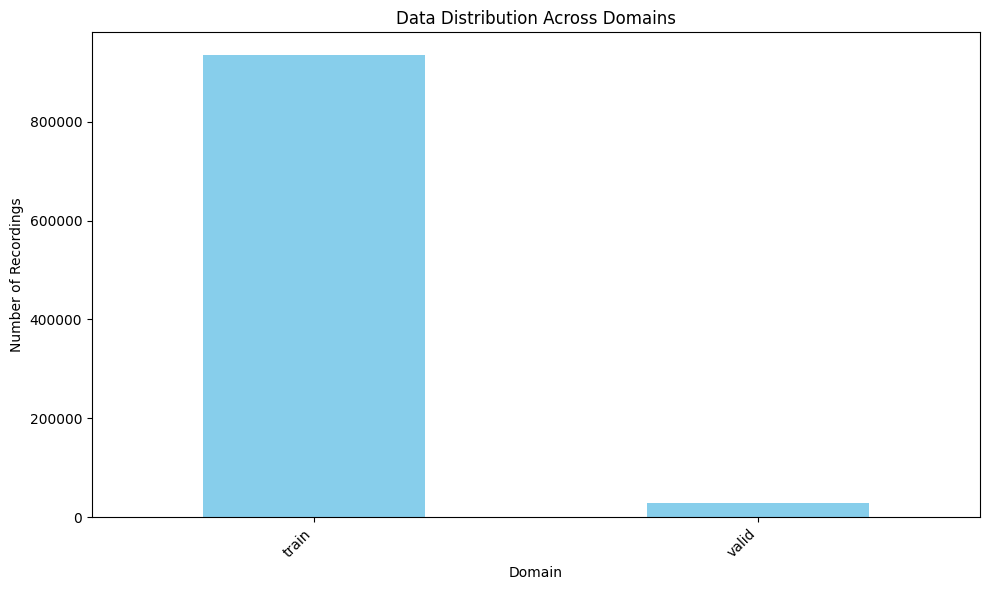

In [7]:
domain_counts = train_df['split'].value_counts()

# Plot the data distribution
plt.figure(figsize=(10, 6))
domain_counts.plot(kind='bar', color='skyblue')
plt.title("Data Distribution Across Domains")
plt.xlabel("Domain")
plt.ylabel("Number of Recordings")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
for idx in random_indices:
    row = train_df.iloc[idx]
    audio_file_path = os.path.join(train_data_dir, f"{row['id']}.mp3")

    # Load the audio file using librosa
    audio, sr = librosa.load(audio_file_path, sr=None)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(audio)
    plt.title(f"Waveform - Audio File ID: {row['id']}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    # Plot the log Mel spectrogram
    plt.figure(figsize=(10, 4))
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Log Mel Spectrogram - Audio File ID: {row['id']}")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.show()

# **Text Preprocessing**

In [ ]:
# Select the first 5 transcriptions
transcriptions = train_df['sentence'][:5].tolist()

# Convert transcriptions to lowercase
transcriptions_lower = [transcription.lower() for transcription in transcriptions]

# Remove punctuation
translator = str.maketrans("", "", string.punctuation)
transcriptions_no_punct = [transcription.translate(translator) for transcription in transcriptions_lower]

# Tokenization
nltk.download('punkt')  
transcriptions_tokens = [word_tokenize(transcription) for transcription in transcriptions_no_punct]


nltk.download('stopwords')  
stop_words = set(stopwords.words('bengali'))
transcriptions_no_stopwords = [
    [word for word in tokens if word not in stop_words]
    for tokens in transcriptions_tokens
]

nltk.download('wordnet')  
stemmer = PorterStemmer()
transcriptions_stemmed = [
    [stemmer.stem(word) for word in tokens]
    for tokens in transcriptions_no_stopwords
]

# Print the preprocessed transcriptions
for i, transcription in enumerate(transcriptions_stemmed):
    print(f"Preprocessed transcription {i+1}: {' '.join(transcription)}")


In [ ]:
# Select the first 100 transcriptions 
transcriptions = train_df['sentence'].tolist()

# Tokenization
nltk.download('punkt')  # Download the Punkt tokenizer
transcriptions_tokens = [word_tokenize(transcription) for transcription in transcriptions]

# Print the tokenized transcriptions
for i, transcription_tokens in enumerate(transcriptions_tokens):
    if i%100000 == 0:
        print(f"Tokenized transcription {i+1}: {transcription_tokens}")

# **Vocab Analysis**

In [11]:
# Build vocabulary
vocabulary = set()
for transcription_tokens in transcriptions_tokens:
    vocabulary.update(transcription_tokens)

# print("Vocabulary:")
# print(vocabulary)
print(f"Vocabulary Size: {len(vocabulary)}")

Vocabulary Size: 204457


# **Sentence Length Analysis**

(array([1.46812e+05, 3.01428e+05, 2.76002e+05, 1.89254e+05, 3.83470e+04,
        1.00420e+04, 1.62200e+03, 1.13000e+02, 1.10000e+01, 5.00000e+00]),
 array([  2. ,  25.1,  48.2,  71.3,  94.4, 117.5, 140.6, 163.7, 186.8,
        209.9, 233. ]),
 <BarContainer object of 10 artists>)

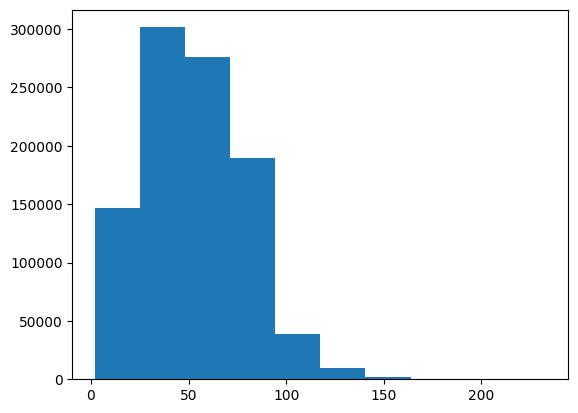

In [12]:
lens = train_df.sentence.apply(lambda x: len(x))
plt.hist(lens)

In [ ]:
# Compute descriptive statistics
sentence_lengths = [len(tokens) for tokens in transcriptions_tokens]
min_length = min(sentence_lengths)
max_length = max(sentence_lengths)
mean_length = sum(sentence_lengths) / len(sentence_lengths)
median_length = sorted(sentence_lengths)[len(sentence_lengths) // 2]

# Plot the distribution of sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=50, color='skyblue', edgecolor='black')
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median_length, color='green', linestyle='dashed', linewidth=2, label='Median')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.legend()
plt.show()

# Print the descriptive statistics
print("Descriptive Statistics:")
print(f"Minimum Sentence Length: {min_length}")
print(f"Maximum Sentence Length: {max_length}")
print(f"Mean Sentence Length: {mean_length:.2f}")
print(f"Median Sentence Length: {median_length}")

# **Word Frequency Analysis**

In [ ]:
# Flatten the list of tokens
all_tokens = [token for tokens in transcriptions_tokens for token in tokens]

# Count word frequency
word_frequency = Counter(all_tokens)

# Print the word frequency analysis
print("Word Frequency:")
plt.plot(word_frequency.values())

In [ ]:
# Calculate the number of unique words in each sentence
sentences = train_df['sentence'].tolist()
unique_word_counts = [len(set(sentence.split())) for sentence in sentences]

# Compute descriptive statistics
min_unique_words = min(unique_word_counts)
max_unique_words = max(unique_word_counts)
mean_unique_words = sum(unique_word_counts) / len(unique_word_counts)
median_unique_words = sorted(unique_word_counts)[len(unique_word_counts) // 2]

# Plot the distribution of unique word counts
plt.figure(figsize=(10, 6))
plt.hist(unique_word_counts, bins=50, color='lightcoral', edgecolor='black')
plt.axvline(mean_unique_words, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median_unique_words, color='green', linestyle='dashed', linewidth=2, label='Median')
plt.xlabel('Number of Unique Words')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Words in Transcriptions')
plt.legend()
plt.show()

# Print the descriptive statistics
print("Descriptive Statistics:")
print(f"Minimum Number of Unique Words: {min_unique_words}")
print(f"Maximum Number of Unique Words: {max_unique_words}")
print(f"Mean Number of Unique Words: {mean_unique_words:.2f}")
print(f"Median Number of Unique Words: {median_unique_words}")

In [ ]:
# Select the first 1000 sentences 
sentences = train_df['sentence'][:10000].tolist()

# Tokenization using NLTK
nltk.download('punkt')  # Download the Punkt tokenizer
sentences_tokens = [word_tokenize(sentence) for sentence in sentences]


# Remove Bengali stopwords
sentences_no_stopwords = [
    [word for word in tokens if word not in stop_words]
    for tokens in sentences_tokens
]

# Convert tokenized sentences back to strings
sentences_processed = [' '.join(tokens) for tokens in sentences_no_stopwords]

# Create a CountVectorizer to convert text data to a bag-of-words representation
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(sentences_processed)

# Perform LDA topic modeling
n_topics = 10  # Number of topics to discover
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(X)

# Get the top words for each topic
feature_names = vectorizer.get_feature_names_out()
top_words_per_topic = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-4:-1]]
    top_words_per_topic.append(top_words)

# Print the top words for each topic
for i, top_words in enumerate(top_words_per_topic):
    print(f"Topic {i + 1}: {' '.join(top_words)}")
    

# **Domain Analysis**

In [ ]:
for idx in np.arange(5):
    audio_file_path = f'{domains}/{DOMAINS[idx]}'

    # Load the audio file using librosa
    audio, sr = librosa.load(audio_file_path, sr=None)

    # Print DOMAIN
    print(DOMAINS[idx])
    ipd.display(ipd.Audio(audio, rate=sr))

In [ ]:
# Define the list of domains and their corresponding audio files
DOMAINS = [
    'Audiobook.wav', 'Parliament Session.wav', 'Bangladeshi TV Drama.wav',
    'Poem Recital.wav', 'Bengali Advertisement.wav', 'Puthi Literature.wav',
    'Cartoon.wav', 'Slang Profanity.mp3', 'Debate.wav', 'Stage Drama Jatra.wav',
    'Indian TV Drama.wav', 'Talk Show Interview.wav', 'Movie.wav', 'Telemedicine.mp3',
    'News Presentation.wav', 'Waz Islamic Sermon.wav', 'Online Class.wav'
]

# Visualize the audio files and play them
for idx in np.arange(5):
    audio_file_path = os.path.join(domains, DOMAINS[idx])

    # Load the audio file using librosa
    audio, sr = librosa.load(audio_file_path, sr=None)

    # Plot the waveform using the basic matplotlib plot function
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
    plt.title(f'Waveform - {DOMAINS[idx]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - {DOMAINS[idx]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

    # Play the audio
    print(f"Audio: {DOMAINS[idx]}")
    ipd.display(ipd.Audio(audio, rate=sr))


# **Model Building**

## **External Package Installation**

In [19]:
# # Define your package directory
# package_dir = "E:\\Studies\\11th Semester\\425\\Project\\Dataset\\python packages"

# # Install jiwer
# !pip install "{package_dir}\\jiwer\\jiwer-2.3.0-py3-none-any.whl"

# # Install bnunicodenormalizer
# !pip install "{package_dir}\\normalizer\\bnunicodenormalizer-0.0.24.tar.gz"

# # Install pyctcdecode
# !pip install "{package_dir}\\pyctcdecode\\attrs-22.1.0-py2.py3-none-any.whl"
# !pip install "{package_dir}\\pyctcdecode\\exceptiongroup-1.0.0rc9-py3-none-any.whl"
# !pip install "{package_dir}\\pyctcdecode\\hypothesis-6.54.4-py3-none-any.whl"
# !pip install "{package_dir}\\pyctcdecode\\numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl"
# !pip install "{package_dir}\\pyctcdecode\\pygtrie-2.5.0.tar.gz"
# !pip install "{package_dir}\\pyctcdecode\\sortedcontainers-2.4.0-py2.py3-none-any.whl"
# !pip install "{package_dir}\\pyctcdecode\\pyctcdecode-0.4.0-py2.py3-none-any.whl"

## **Loading Dependencies**

In [21]:
import typing as tp  # Typing module for type hints
from pathlib import Path  # For working with file paths
from functools import partial  # To create partial functions
from dataclasses import dataclass, field  # For creating data classes

import pandas as pd 
import pyctcdecode  # For CTC decoding
import numpy as np  
from tqdm.notebook import tqdm  # For creating progress bars

import librosa  # For audio processing

import pyctcdecode  # For CTC decoding
import kenlm  # For working with KenLM language model
import torch  # PyTorch library for machine learning
from transformers import Wav2Vec2Processor, Wav2Vec2ProcessorWithLM, Wav2Vec2ForCTC  # For loading and processing Wav2Vec2 models
from bnunicodenormalizer import Normalizer  # For Bengali Unicode normalization

c:\Users\tanji\anaconda3\envs\425\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Setting Paths and Parameters**

In [22]:
from pathlib import Path

# Define paths and parameters for the project
DATA = Path(r"E:\\Studies\\11th Semester\\425\\Project\\Dataset\\bengaliai-speech")
TRAIN = DATA / "train_mp3s"
TEST = DATA / "test_mp3s"
SAMPLING_RATE = 16_000
MODEL_PATH = Path(r"E:\Studies\\11th Semester\\425\Project\\Dataset\\Wav2Vec2\\indicwav2vec_v1_bengali")
LM_PATH = Path(r"E:\Studies\\11th Semeste\\425\\Project\\Dataset\\Wav2Vec2\\wav2vec2-xls-r-300m-bengali\\language_model")


## **Loading Speech Recognition Model**

In [ ]:
# Load Wav2Vec2 model and processor
model = Wav2Vec2ForCTC.from_pretrained(MODEL_PATH)  # CTC instance
# processor will be responsible for handling the audion data
processor = Wav2Vec2Processor.from_pretrained(MODEL_PATH)

In [ ]:
# build the vocabulary and a decoder

# Get the vocabulary from the model's tokenizer
vocab_dict = processor.tokenizer.get_vocab()
print('lENGTH OF THE VOCABULARY: ',len(vocab_dict))
vocab_dict


## **Building Vocabulary and CTC Decoder**

In [ ]:
from pathlib import Path

# Sort the vocabulary based on token IDs
sorted_vocab_dict = {k: v for k, v in sorted(vocab_dict.items(), key=lambda item: item[1])}

# Define the language model path
LM_PATH = Path(r"E:\Studies\11th Semester\425\Project\Dataset\Wav2Vec2\wav2vec2-xls-r-300m-bengali\language_model")

# Build a CTC decoder using the sorted vocabulary and a language model
decoder = pyctcdecode.build_ctcdecoder(
    list(sorted_vocab_dict.keys()),  # Vocabulary keys
    str(LM_PATH / "5gram.bin"),  # Path to the language model file
)


## **Creating Combined Processor for Model Input and Decoding**

In [27]:
# Create a combined processor for Wav2Vec2 model input and language model decoding
processor_with_lm = Wav2Vec2ProcessorWithLM(
    feature_extractor=processor.feature_extractor,  # Feature extractor for audio data
    tokenizer=processor.tokenizer,  # Tokenizer for text data
    decoder=decoder  # Decoder for converting model output to text
)

## **Defining a Custom Dataset Class**

In [28]:
import torch
from torch.utils.data import Dataset

class BengaliSRTestDataset(Dataset):
    # A custom dataset class for handling Bengali speech test data
    
    def __init__(self, audio_paths: list[str], sampling_rate: int):
        # Constructor to initialize the dataset
        
        # Store the list of audio file paths
        self.audio_paths = audio_paths
        
        # Store the sampling rate used for audio processing
        self.sampling_rate = sampling_rate
    
    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.audio_paths)
    
    def __getitem__(self, index: int):
        # Get a sample from the dataset given an index
        
        # Get the audio file path corresponding to the index
        audio_path = self.audio_paths[index]
        
        # Get the sampling rate from the dataset settings
        sr = self.sampling_rate
        
        # Load the audio file using librosa, specifying the desired sampling rate
        # 'mono=False' indicates to load the audio as a multi-channel signal
        # [0] at the end gets the audio signal (the first element of the returned tuple)
        audio_signal = librosa.load(audio_path, sr=sr, mono=False)[0]
        
        # Return the loaded audio signal as the sample
        return audio_signal


## **Creating Test Dataset and DataLoader**

In [29]:
test = pd.read_csv(DATA / "sample_submission.csv", dtype={"id": str})
print(test.head())

             id                                           sentence
0  0f3dac00655e  এছাড়াও নিউজিল্যান্ড এ ক্রিকেট দলের হয়েও খেলছ...
1  a9395e01ad21  এছাড়াও নিউজিল্যান্ড এ ক্রিকেট দলের হয়েও খেলছ...
2  bf36ea8b718d  এছাড়াও নিউজিল্যান্ড এ ক্রিকেট দলের হয়েও খেলছ...


In [30]:
test_audio_paths = [str(TEST / f"{aid}.mp3") for aid in test["id"].values]

In [31]:
# Create a dataset for testing using the list of test audio paths and specified sampling rate
test_dataset = BengaliSRTestDataset(
    test_audio_paths, SAMPLING_RATE
)

# Define a partial function for collating samples into batches
collate_func = partial(
    processor_with_lm.feature_extractor,
    return_tensors="pt", sampling_rate=SAMPLING_RATE,
    padding=True,
)

# Create a data loader for testing
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=4, shuffle=False,
    num_workers=0, collate_fn=collate_func, drop_last=False,
    pin_memory=True,
)


## **Setting Up the Model for Inference**

In [32]:
if not torch.cuda.is_available():
    device = torch.device("cpu")
else:
    device = torch.device("cuda")
print(device)

# attach cpu or gpu
model = model.to(device)
model = model.eval()
model = model.half()
torch.cuda.empty_cache()

cuda


## **Performing Model Inference**

In [33]:
from tqdm import tqdm

pred_sentence_list = []  # Initialize an empty list to store predicted sentences

# Perform inference without gradient computation because we are not fine tuning so we don't want to change the weights
with torch.no_grad():
    for batch in tqdm(test_loader):  # Iterate through batches of test data
        x = batch["input_values"]  # Extract the input audio features from the batch
        x = x.to(device, non_blocking=True)  # Move the input data to the device (GPU)
        
        # Use automatic mixed precision for faster and more memory-efficient inference
        with torch.cuda.amp.autocast(True):
            y = model(x).logits  # Get the model's output logits
        del x
        y = y.detach().cpu().numpy()  # Move the logits to the CPU and convert to a numpy array
        
        for l in y:  # Iterate through the logits of the batch
            # Decode the logits into a sentence using the LM with beam search decoding
            sentence = processor_with_lm.decode(l, beam_width=64).text
            pred_sentence_list.append(sentence)  # Append the predicted sentence to the list


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


## **Postprocessing Predicted Sentences**

In [34]:
bnorm = Normalizer()  # Create a Normalizer object for text normalization

def postprocess(sentence):
    # Define a postprocessing function to clean up and format predicted sentences
    
    period_set = set([".", "?", "!", "।"])  # Set of sentence-ending punctuation
    
    # Split the sentence into words and apply normalization using the Normalizer
    _words = [bnorm(word)['normalized'] for word in sentence.split() if word]
    
    sentence = " ".join(_words)
    
    if not sentence.endswith(tuple(period_set)):
        sentence += "।"
    return sentence


In [35]:
pp_pred_sentence_list = [
    postprocess(s) for s in tqdm(pred_sentence_list)]

100%|██████████| 3/3 [00:00<00:00, 460.68it/s]


In [50]:
import sounddevice as sd
import numpy as np
import torch

# Function to record audio from the microphone
def record_audio(duration=5, fs=16000):
    print("Recording...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()  # Wait until recording is finished
    print("Recording finished")
    return recording.flatten()

# Function to make predictions from audio
def recognize_speech(model, processor, audio, device):
    # Preprocess the audio to model's expected format
    input_values = processor(audio, sampling_rate=16000, return_tensors="pt").input_values
    input_values = input_values.to(device)

    # Convert input_values to the same dtype as model (half precision)
    input_values = input_values.half()

    # Perform inference with the model
    with torch.no_grad():
        logits = model(input_values).logits

    # Ensure logits are two-dimensional (time, vocabulary)
    if len(logits.shape) == 1:
        logits = logits.unsqueeze(0)

    # Convert logits to numpy array
    logits = logits.cpu().numpy()

    # Decode the logits to text using the processor's decode method
    # Extract only the 'text' attribute from the output
    transcription = processor.decode(logits[0]).text
    return transcription


# Record audio from microphone
audio_data = record_audio(duration=5)

# Recognize speech
transcription = recognize_speech(model, processor_with_lm, audio_data, device)
print("Recognized Text:", transcription)



Recording...
Recording finished
Recognized Text: আমি আমি যদি কথা বলি এখানে আসবে


<div style="text-align: center;">
    <span style="font-size:50px;"><b>Understanding and Responding</b></span>
</div>


## **Clearing GPU Cache**

In [ ]:
import torch
torch.cuda.empty_cache()

## **Data Loading and Preprocessing**

In [ ]:
import pandas as pd

# Load
df = pd.read_csv("E:/Studies/11th Semester/425/Project/train.csv")

# Preprocess
df['text'] = df['context'] + "\n" + df['reply']
df['text'].to_csv("E:/Studies/11th Semester/425/Project/train.txt", index=False, header=False)

## **Setting Up Language Model for Fine-Tuning**

In [ ]:
import pandas as pd
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
from transformers import TextDataset, DataCollatorForLanguageModeling
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings('ignore')

In [ ]:
local_model_path = "D:\\fall 23\\cse425\\425 project\\gpt2-bengali"

tokenizer = PreTrainedTokenizerFast(tokenizer_file=f"{local_model_path}/tokenizer.json")
model = GPT2LMHeadModel.from_pretrained(local_model_path)

In [ ]:
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="E:\\Studies\\11th Semester\\425\\Project\\train.txt",
    block_size=128
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

## **Model Training Loop**

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.train()
for epoch in range(5):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False)
    for batch in progress_bar:
        inputs = batch[0].to(device)  # batch is a list with a single tensor
        labels = inputs

        outputs = model(inputs, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the progress bar with the loss value
        progress_bar.set_postfix({'loss': loss.item()})

## **Saving the Fine-Tuned Model**

In [ ]:
model.save_pretrained("./gpt2-bengali-finetuned-final")


## **Setting Up an Interactive Voice Bot**

In [ ]:
import sounddevice as sd
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, GPT2LMHeadModel, PreTrainedTokenizerFast
from normalizer import normalize
import logging
from transformers import logging as hf_logging
import warnings
# from transformers import LogitsProcessorList, MinLengthLogitsProcessor, RepetitionPenaltyLogitsProcessor

# Suppress warnings from sounddevice
warnings.filterwarnings(action='ignore')

# Suppress certain warnings from transformers
hf_logging.set_verbosity_error()

# Suppress other warnings (like those from loading models)
logging.getLogger("transformers").setLevel(logging.ERROR)

# Function to record audio from the microphone
def record_audio(duration=5, fs=16000):
    print("Recording...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()  # Wait until recording is finished
    print("Recording finished")
    return recording.flatten()

# Function to recognize speech using Wav2Vec2
def recognize_speech(model, processor, audio, device):
    input_values = processor(audio, sampling_rate=16000, return_tensors="pt").input_values
    input_values = input_values.to(device)

    with torch.no_grad():
        logits = model(input_values).logits

    if len(logits.shape) == 1:
        logits = logits.unsqueeze(0)

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0], skip_special_tokens=True)
    return transcription

# Function to generate a response
def generate_response(input_text, model, tokenizer, device):
    if not input_text.strip():  # Check for empty string
        return "No input provided."

    # Ensure "।" is in the tokenizer's vocabulary
    if "।" not in tokenizer.get_vocab():
        tokenizer.add_special_tokens({'additional_special_tokens': ["।"]})
        model.resize_token_embeddings(len(tokenizer))  # Resize model embeddings to fit the new token

    inputs = tokenizer(input_text, return_tensors="pt", padding=True)
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Set "।" as the eos_token_id for generation
    eos_token_id = tokenizer.convert_tokens_to_ids("।")

    # Decoding settings
    generation_parameters = {
    "max_length": 128, 
    "temperature": 0.7,  
    "num_beams": 3,  
    "no_repeat_ngram_size": 2,  
    "early_stopping": True,  
    "attention_mask": attention_mask, 
    "eos_token_id": eos_token_id,  
    "num_return_sequences": 1,  
}


    with torch.no_grad():
        output_ids = model.generate(input_ids, **generation_parameters)

    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Find the first occurrence of "।" and cut off the rest
    end_idx = response.find("।")
    if end_idx != -1:
        response = response[:end_idx + 1]

    # Remove any unwanted characters
    response = response.replace("?", "").strip()

    # Remove any part of the response that repeats the input
    if input_text in response:
        response = response.replace(input_text, '').strip()

    return response


# Load the Wav2Vec2 model and processor
wav2vec2_model_path = r"E:\\Studies\\11th Semester\\425\\Project\\Dataset\\Wav2Vec2\\indicwav2vec_v1_bengali"
wav2vec2_model = Wav2Vec2ForCTC.from_pretrained(wav2vec2_model_path)
wav2vec2_processor = Wav2Vec2Processor.from_pretrained(wav2vec2_model_path)

# Load your fine-tuned GPT-2 Bengali model
gpt2_model_path = "E:\\Studies\\11th Semester\\425\\Project\\gpt2-bengali-finetuned-final"
gpt2_tokenizer = PreTrainedTokenizerFast(tokenizer_file=f"{gpt2_model_path}/tokenizer.json")


# Set padding token to EOS token
# If your tokenizer does not have an EOS token, you'll need to add a new special token for padding
if gpt2_tokenizer.eos_token is None:
    gpt2_tokenizer.add_special_tokens({'eos_token': '[EOS]'})
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Ensure the model's config pad token id is set
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_path)
gpt2_model.config.pad_token_id = gpt2_tokenizer.eos_token_id


# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wav2vec2_model.to(device)
gpt2_model.to(device)

# Start the conversation loop
print("The Voice Bot is ready to talk! Press Ctrl+C to end the conversation.")

try:
    while True:
        audio_data = record_audio(duration=5)
        if audio_data is not None and audio_data.size > 0:
            transcription = recognize_speech(wav2vec2_model, wav2vec2_processor, audio_data, device)
            print(f"You: {transcription}")
            response = generate_response(transcription, gpt2_model, gpt2_tokenizer, device)
            print(f"Bot: {response}")
        else:
            print("No audio detected.")

except KeyboardInterrupt:
    print("\nConversation ended.")